In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torchvision
import torchvision.transforms.v2 as transforms
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [3]:
os.environ['KAGGLE_USERNAME'] = "Tazana"
os.environ['KAGGLE_KEY'] = "KGAT_ae7832557eae3064c9a913bae0131472"

!pip install -q kaggle

print("Descargando el dataset...")
!kaggle datasets download -d puneet6060/intel-image-classification

print("Descomprimiendo archivos...")
!mkdir -p kaggle
!unzip -q intel-image-classification.zip -d kaggle/

print("Archivos listos.")

Descargando el dataset...
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 86% 298M/346M [00:00<00:00, 848MB/s] 
100% 346M/346M [00:00<00:00, 764MB/s]
Descomprimiendo archivos...
Archivos listos.


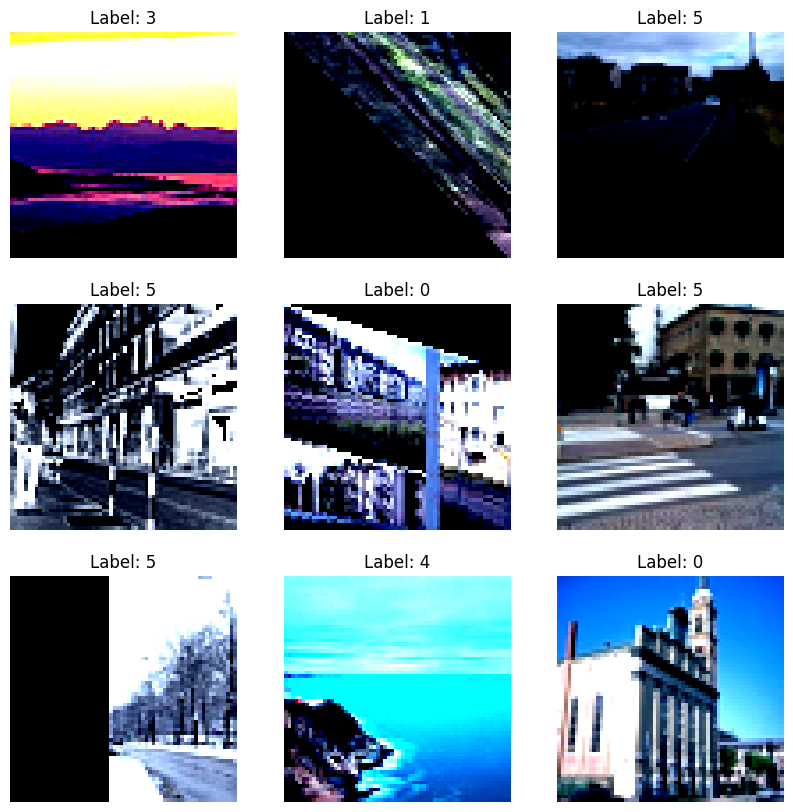

In [7]:
batch_size = 128
images_size = (64, 64)
epochs = 50
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transformaciones
train_transform = transforms.Compose([
    transforms.Resize(images_size),
    transforms.TrivialAugmentWide(),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize(images_size),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=mean, std=std)
])

# Cargar datasets
train_dataset = torchvision.datasets.ImageFolder(
    root='kaggle/seg_train/seg_train',
    transform=train_transform
)

test_dataset = torchvision.datasets.ImageFolder(
    root='kaggle/seg_test/seg_test',
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# Ver ejemplos
for images, labels in train_loader:
    images = images * 0.5 + 0.5
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img_to_show = images[i].permute(1, 2, 0)

        plt.imshow(img_to_show)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break

In [8]:
# Crear modelo
input_size = 3 * images_size[0] * images_size[1]
n_classes = len(train_dataset.classes)

model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(input_size, 4096),
    nn.BatchNorm1d(4096),
    nn.GELU(),
    nn.Dropout(0.4),

    nn.Linear(4096, 1024),
    nn.BatchNorm1d(1024),
    nn.GELU(),
    nn.Dropout(0.3),

    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.GELU(),
    nn.Dropout(0.2),

    nn.Linear(512, n_classes)
)

model = model.to(device)
if hasattr(torch, 'compile'):
    try:
        model = torch.compile(model)
        print("Model compilation (torch.compile) exitosa.")
    except:
        print("torch.compile no soportado, continuando normal.")

print(model)
print(f"\nParámetros: {sum(p.numel() for p in model.parameters()):,}")

Model compilation (torch.compile) exitosa.
OptimizedModule(
  (_orig_mod): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=4096, bias=True)
    (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): GELU(approximate='none')
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=4096, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): GELU(approximate='none')
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=512, out_features=6, bias=True)
  )
)

Parámetros: 55,070,214


In [9]:
# Loss y optimizer
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [10]:
def train():
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)

        output = model(x)
        batch_loss = loss_function(output, y)

        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()
        correct += (output.argmax(1) == y).sum().item()
        total += y.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total

    print(f'Train - Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

In [11]:
def validate():
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            output = model(x)
            batch_loss = loss_function(output, y)

            total_loss += batch_loss.item()
            correct += (output.argmax(1) == y).sum().item()
            total += y.size(0)

    epoch_loss = total_loss / len(test_loader)
    epoch_acc = correct / total

    print(f'Valid - Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

In [12]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
path_checkpoint = 'checkpoint.pth'
start_epoch = 0

# if os.path.exists(path_checkpoint):
#     print(f"Cargando checkpoint: {path_checkpoint}...")
#     checkpoint = torch.load(path_checkpoint, map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     best_val_loss = checkpoint['val_loss']
#     print(f"Checkpoint cargado. Mejor Loss: {best_val_loss:.4f}")

for epoch in range(start_epoch, epochs):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train()
    val_loss, val_acc = validate()

    scheduler.step()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }
        torch.save(checkpoint, path_checkpoint)
        print(f"Mejor modelo guardado (Loss: {val_loss:.4f}) en epoca {epoch}")

Epoch: 0


W0227 21:46:10.450000 1626 torch/_inductor/utils.py:1679] [0/0] Not enough SMs to use max_autotune_gemm mode


Train - Loss: 1.5504 Accuracy: 0.4082
Valid - Loss: 1.3370 Accuracy: 0.5370
Mejor modelo guardado (Loss: 1.3370) en epoca 0
Epoch: 1
Train - Loss: 1.4550 Accuracy: 0.4656
Valid - Loss: 1.2735 Accuracy: 0.5827
Mejor modelo guardado (Loss: 1.2735) en epoca 1
Epoch: 2
Train - Loss: 1.4152 Accuracy: 0.4935
Valid - Loss: 1.2296 Accuracy: 0.5903
Mejor modelo guardado (Loss: 1.2296) en epoca 2
Epoch: 3
Train - Loss: 1.3868 Accuracy: 0.5095
Valid - Loss: 1.2462 Accuracy: 0.5910
Epoch: 4
Train - Loss: 1.3720 Accuracy: 0.5110
Valid - Loss: 1.2159 Accuracy: 0.6090
Mejor modelo guardado (Loss: 1.2159) en epoca 4
Epoch: 5
Train - Loss: 1.3463 Accuracy: 0.5274
Valid - Loss: 1.2005 Accuracy: 0.6120
Mejor modelo guardado (Loss: 1.2005) en epoca 5
Epoch: 6
Train - Loss: 1.3276 Accuracy: 0.5378
Valid - Loss: 1.1997 Accuracy: 0.6217
Mejor modelo guardado (Loss: 1.1997) en epoca 6
Epoch: 7
Train - Loss: 1.3094 Accuracy: 0.5462
Valid - Loss: 1.1687 Accuracy: 0.6407
Mejor modelo guardado (Loss: 1.1687) en e

In [23]:
# Definición del Dataset de Predicción (sin etiquetas)
class PredictionDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        # Filtramos solo archivos de imagen y los ordenamos
        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Configuración del Loader
predict_dir = 'kaggle/seg_pred/seg_pred'
pred_dataset = PredictionDataset(root_dir=predict_dir, transform=test_transform)
pred_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)

In [24]:
def generate_final_csv():
    # Cargar el mejor modelo si existe el checkpoint
    if os.path.exists(path_checkpoint):
        checkpoint = torch.load(path_checkpoint, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Modelo cargado desde el checkpoint (Época {checkpoint['epoch']}).")

    model.eval()
    results = []

    print(f"Generando predicciones para {len(pred_dataset)} imágenes...")

    with torch.no_grad():
        for images, filenames in pred_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(filenames)):
                results.append({
                    'id': filenames[i],
                    'pred': preds[i].item()
                })
    df = pd.DataFrame(results, columns=['id', 'pred'])
    df.to_csv('predictions.csv', index=False)
    print("\nArchivo 'predictions.csv' creado exitosamente.")
    return df

# Ejecutar y mostrar los primeros resultados
df_final = generate_final_csv()
print("\nPrimeras 5 filas del archivo:")
print(df_final.head())

Modelo cargado desde el checkpoint (Época 42).
Generando predicciones para 7301 imágenes...

Archivo 'predictions.csv' creado exitosamente.

Primeras 5 filas del archivo:
          id  pred
0  10004.jpg     5
1  10005.jpg     3
2  10012.jpg     5
3  10013.jpg     3
4  10017.jpg     3


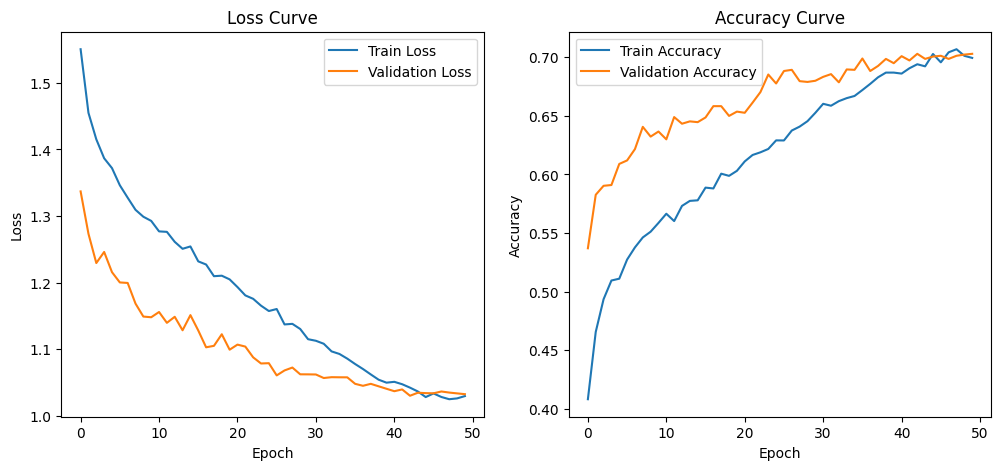

In [25]:
# Gráficas de pérdida y accuracy
plt.figure(figsize=(12,5))

# Perdida
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()